In [26]:
from dpu_utils.utils import run_and_debug, RichPath
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
from rdkit import Chem

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500, 500

metapath = RichPath.create('./fs_mol/preprocessing/utils/helper_files/')
path = metapath.join("metadata.pkl.gz")
metadata = path.read_by_file_suffix()
atom_feature_extractors = metadata["feature_extractors"]

m = Chem.MolFromSmiles('CCC(COC(=O)[C@@H](NP(=O)(Oc1ccccc1)OC[C@H]1O[C@@]([C@@H]([C@@H]1O)O)(C#N)c1ccc2n1ncnc2N)C)CC')

atoms = list(m.GetAtoms())

In [29]:
atoms[0].IsInRing()

False

In [30]:
atom_feature_extractors[4].feature_width

1

In [15]:
# Formal Charge = 
atom_feature_extractors[2].featurise(atoms[0])

array([0., 0., 1., 0., 0., 0.])

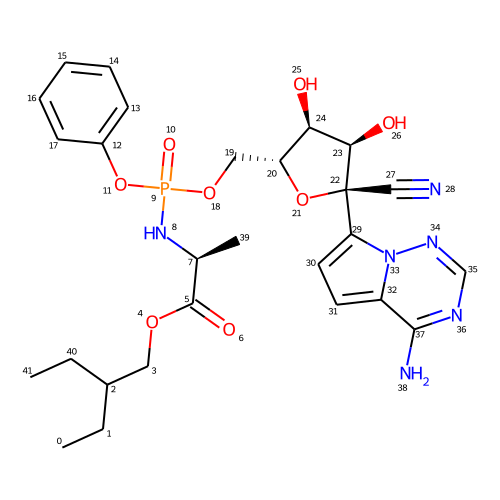

In [9]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

m = Chem.MolFromSmiles('CCC(COC(=O)[C@@H](NP(=O)(Oc1ccccc1)OC[C@H]1O[C@@]([C@@H]([C@@H]1O)O)(C#N)c1ccc2n1ncnc2N)C)CC')

m

# atoms = m.GetAtoms()

# atoms = list(atoms)

In [6]:
atoms = list(m.GetAtoms())

at_degrees = [atom.GetDegree() for atom in atoms]

at_degrees[5]

3

In [17]:
atom_feature_extractors[1].featurise(atoms[0]) # 15 + 7 + 6  + 3 + 1?

array([0., 1., 0., 0., 0., 0., 0.])

In [18]:
atom_feature_extractors[1]._min_known_degree

1

In [2]:
atom_feature_extractors

In [19]:
atom_featurizer = atom_feature_extractors[0]

atom_featurizer._atom_type_vocabulary

{'UNK': 0,
 'C': 1,
 'Br': 6,
 'N': 2,
 'O': 3,
 'S': 4,
 'Cl': 5,
 'F': 7,
 'P': 8,
 'I': 9,
 'B': 12,
 'Si': 11,
 'Se': 13,
 'Na': 10,
 'K': 14}

In [22]:
from rdkit.Chem.Draw import rdMolDraw2D

smi = 'c1cc(F)ccc1Cl'
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts('ClccccF')
hit_ats = list(mol.GetSubstructMatch(patt))
print(hit_ats)
hit_bonds = []
for bond in patt.GetBonds():
   aid1 = hit_ats[bond.GetBeginAtomIdx()]
   aid2 = hit_ats[bond.GetEndAtomIdx()]
   hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
d = rdMolDraw2D.MolDraw2DCairo(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,
                                   highlightBonds=hit_bonds)
d.WriteDrawingText("./images/1.png")

[7, 6, 5, 4, 2, 3]


In [6]:
from fs_mol.data import FSMolDataset, DataFold
from fs_mol.custom.utils import convert_to_pyg_graph

dataset = FSMolDataset.from_directory('./datasets/fs-mol')

valid_task_iterable = dataset.get_task_reading_iterable(DataFold.VALIDATION)
task = next(iter(valid_task_iterable))
print(task.name)

CHEMBL1243966


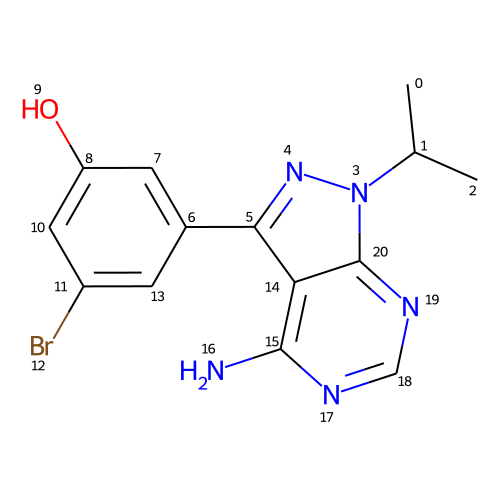

In [27]:
example_mol = Chem.MolFromSmiles('CC(C)n1nc(-c2cc(O)cc(Br)c2)c2c(N)ncnc21')

example_mol

In [60]:
pyg_graph = convert_to_pyg_graph(task.samples[0])

In [76]:
node_num, _ = pyg_graph.x.size()
edge_index = pyg_graph.edge_index.numpy()
print(idx_neigh)
sub_num = int(node_num * 0.2)
print(sub_num)
idx_sub = [np.random.randint(node_num, size=1)[0]]
idx_neigh = set([n for n in edge_index[1][edge_index[0]==idx_sub[0]]])

print(edge_index[0]==idx_sub[0])
print(edge_index[1])
edge_index[1][edge_index[0]==idx_sub[0]]

{5}
4
[False False False False False False False False False False False False
 False  True False  True False False False False False False False]
[ 1  2  3  4  6  8  9 11 12 14 16 17 19  3  6 14  5  7 10 13 15 18 20]


array([ 3, 14])

In [55]:
from fs_mol.augmentation_transforms import SubGraphAugmentation

auger = SubGraphAugmentation(0.8)

In [56]:
augmented_graph = auger(pyg_graph)

1
[0]


In [57]:
augmented_graph

Data(x=[2, 32], edge_index=[2, 1], edge_attr=[1], y=1)

In [58]:
augmented_graph.x

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.]])

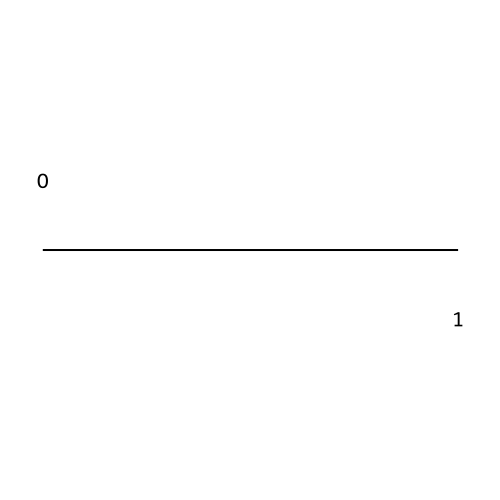

In [59]:
from fs_mol.utils.visualization import convert_graph_to_mol


convert_graph_to_mol(augmented_graph)

### Align Molecules:

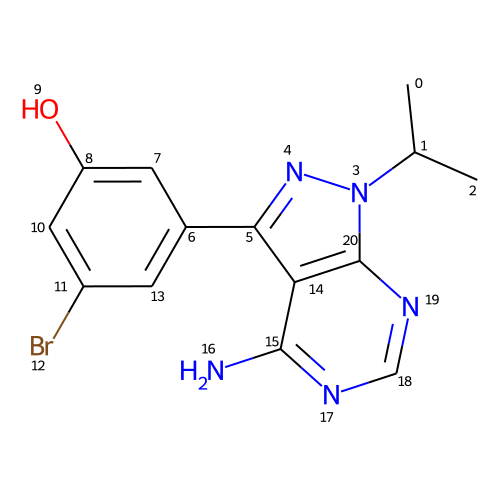

In [42]:
from fs_mol.utils.visualization import convert_graph_to_mol
import importlib, sys
from rdkit.Chem import AllChem

importlib.reload(sys.modules['fs_mol.utils.visualization'])

second_mol = convert_graph_to_mol(pyg_graph)

AllChem.Compute2DCoords(example_mol)
AllChem.Compute2DCoords(second_mol)

rms = AllChem.AlignMol(second_mol, example_mol)

second_mol

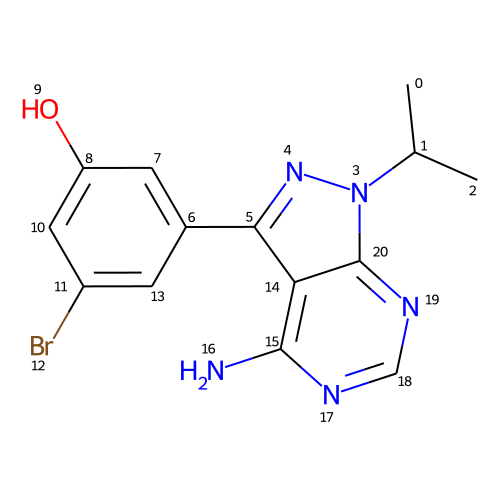

In [40]:
example_mol